In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean
from scipy.stats import linregress, spearmanr


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
# Load gas line map NGC4694_gas_BIN_maps.fits 
gas_path = Path('NGC4694_gas_BIN_maps_extended.fits')
print(f"Loading gas line map from {gas_path}")
with fits.open(gas_path) as hdul:
    HB4861_FLUX = hdul['HB4861_FLUX'].data
    HB4861_FLUX_ERR = hdul['HB4861_FLUX_ERR'].data
    HA6562_FLUX = hdul['HA6562_FLUX'].data
    HA6562_FLUX_ERR = hdul['HA6562_FLUX_ERR'].data
    OIII5006_FLUX = hdul['OIII5006_FLUX'].data
    OIII5006_FLUX_ERR = hdul['OIII5006_FLUX_ERR'].data
    NII6583_FLUX = hdul['NII6583_FLUX'].data
    NII6583_FLUX_ERR = hdul['NII6583_FLUX_ERR'].data
    SII6716_FLUX = hdul['SII6716_FLUX'].data
    SII6716_FLUX_ERR = hdul['SII6716_FLUX_ERR'].data
    SII6730_FLUX = hdul['SII6730_FLUX'].data
    SII6730_FLUX_ERR = hdul['SII6730_FLUX_ERR'].data
    gas_header = hdul[5].header
    hdul.close()

gas_header

Loading gas line map from NGC4694_gas_BIN_maps_extended.fits


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  439                                                  
NAXIS2  =                  440                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =       217.8892138833 / Pixel coordinate of reference point            
CRPIX2  =      220.75194852268 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

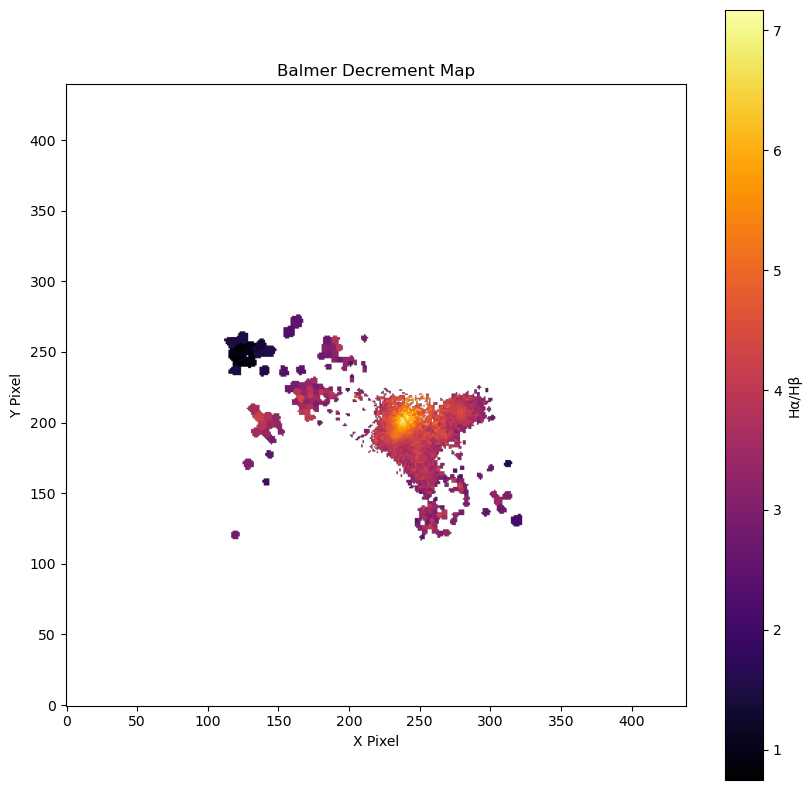

Lowest Balmer Decrement: 0.7495988428135253
Highest Balmer Decrement: 7.167203310740379
Lowest 5 unique non-NaN Balmer Decrement values: [0.74959884 0.7839036  0.78877726 0.79485856 0.79520561]


In [3]:
# Apply a first cut of FLUX/ERR ≥ 5 on every line, 
# at least 22 to get min BD>2.86
# at least 15 to have all SF in BPT diagram
cut = 15
mask_HB = HB4861_FLUX / HB4861_FLUX_ERR >= cut
mask_HA = HA6562_FLUX / HA6562_FLUX_ERR >= cut
# Combine masks for both lines
mask_combined = mask_HB & mask_HA
# Apply the mask to the flux maps
HB4861_FLUX_cut = np.where(mask_combined, HB4861_FLUX, np.nan)
HA6562_FLUX_cut = np.where(mask_combined, HA6562_FLUX, np.nan)

# Balmer-decrement map – H α/H β (start with all spaxels).
BD = HA6562_FLUX_cut / HB4861_FLUX_cut

plt.figure(figsize=(10, 10))
# plt.style.use('dark_background')
plt.imshow(BD, origin='lower', cmap='inferno')
plt.colorbar(label='Hα/Hβ')
plt.title('Balmer Decrement Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

# Print the lowest and highest values of the Balmer decrement map
print(f"Lowest Balmer Decrement: {np.nanmin(BD)}")
print(f"Highest Balmer Decrement: {np.nanmax(BD)}")
# Print lowest 5 non-NaN values (unique values only)
bd_valid = BD[~np.isnan(BD)]
bd_unique = np.unique(bd_valid)
lowest_5_unique = bd_unique[:5]
print(f"Lowest 5 unique non-NaN Balmer Decrement values: {lowest_5_unique}")


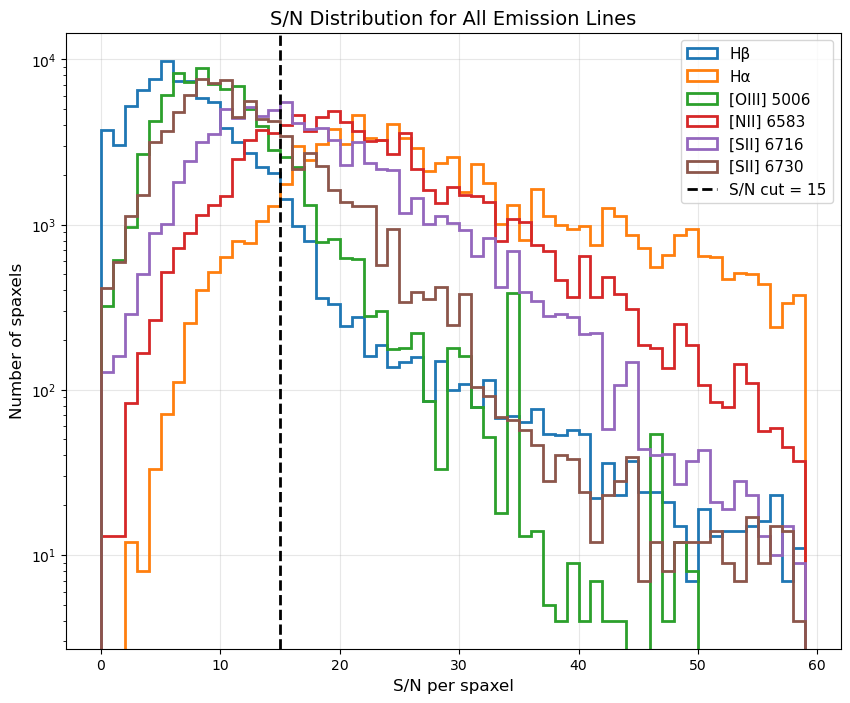

In [4]:
plt.figure(figsize=(10, 8))

for i, (line, flux, err) in enumerate([('Hβ', HB4861_FLUX, HB4861_FLUX_ERR),
                                      ('Hα', HA6562_FLUX, HA6562_FLUX_ERR), 
                                      ('[OIII] 5006', OIII5006_FLUX, OIII5006_FLUX_ERR),
                                      ('[NII] 6583', NII6583_FLUX, NII6583_FLUX_ERR),
                                      ('[SII] 6716', SII6716_FLUX, SII6716_FLUX_ERR),
                                      ('[SII] 6730', SII6730_FLUX, SII6730_FLUX_ERR)]):
    sn = flux/err
    plt.hist(sn[np.isfinite(sn)].ravel(), bins=np.arange(0,60,1), histtype='step', 
             label=line, linewidth=2)

plt.axvline(cut, ls='--', color='k', linewidth=2, label=f'S/N cut = {cut}')
plt.yscale('log')
plt.xlabel('S/N per spaxel', fontsize=12)
plt.ylabel('Number of spaxels', fontsize=12)
plt.title('S/N Distribution for All Emission Lines', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.show()


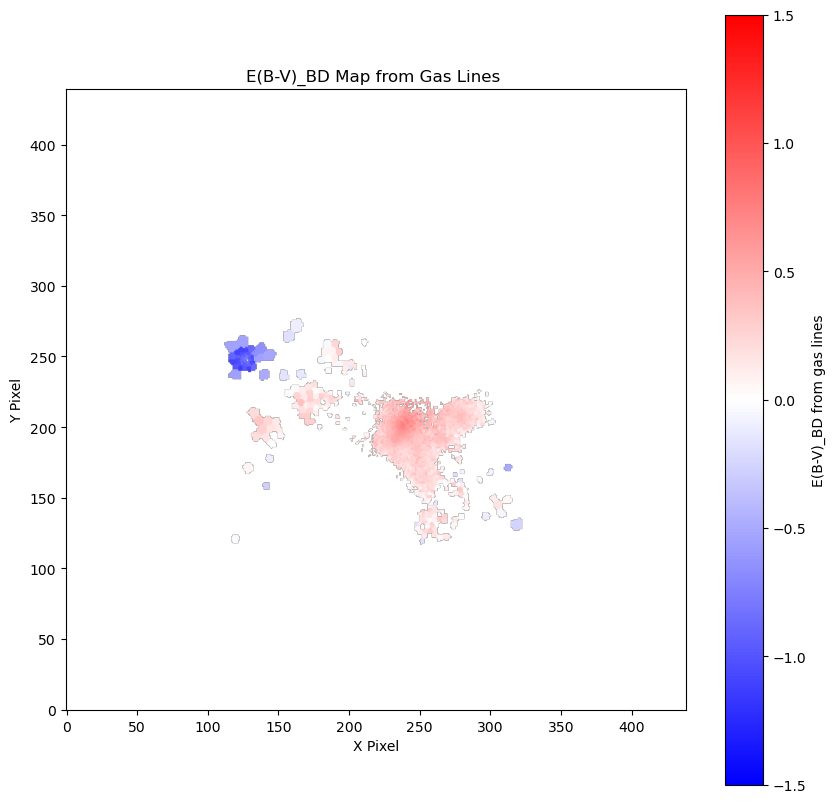

In [5]:
# O'Donnell (1994) update
# k_Hb = 3.609   # 4861 Å
# k_Ha = 2.535   # 6563 Å
# Calzetti (2000)
k_Hb = 4.598 
k_Ha = 3.325
R_int = 2.86

E_BV_BD = 2.5/(k_Hb - k_Ha) * np.log10( (HA6562_FLUX_cut/HB4861_FLUX_cut) / R_int )

plt.figure(figsize=(10, 10))
# plt.style.use('dark_background')
plt.imshow(E_BV_BD, origin='lower', cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(label='E(B-V)_BD from gas lines')
plt.title('E(B-V)_BD Map from Gas Lines ')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [6]:
# Manually set the negative E(B-V) values to zero
# E_BV_BD[E_BV_BD < 0] = np.nan

In [7]:
# ---- line ratios --------------------------------------------------
logN2  = np.log10(NII6583_FLUX / HA6562_FLUX)        # [N II]/Hα
logS2  = np.log10((SII6716_FLUX+SII6730_FLUX) / HA6562_FLUX)   # Σ[S II]/Hα
logO3  = np.log10(OIII5006_FLUX / HB4861_FLUX)       # [O III]/Hβ         

mask_N2 = NII6583_FLUX / NII6583_FLUX_ERR >= cut
mask_S2 = (SII6716_FLUX + SII6730_FLUX) / (SII6716_FLUX_ERR + SII6730_FLUX_ERR) >= cut
mask_O3 = OIII5006_FLUX / OIII5006_FLUX_ERR >= cut
mask_combinedd = mask_combined & mask_N2 & mask_S2 & mask_O3

logN2_cut = np.where(mask_combinedd, logN2, np.nan)
logS2_cut = np.where(mask_combinedd, logS2, np.nan)
logO3_cut = np.where(mask_combinedd, logO3, np.nan)

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_46991/1770318249.py:2: RuntimeWarning: divide by zero encountered in log10
  logN2  = np.log10(NII6583_FLUX / HA6562_FLUX)        # [N II]/Hα
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_46991/1770318249.py:3: RuntimeWarning: divide by zero encountered in log10
  logS2  = np.log10((SII6716_FLUX+SII6730_FLUX) / HA6562_FLUX)   # Σ[S II]/Hα
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_46991/1770318249.py:4: RuntimeWarning: divide by zero encountered in divide
  logO3  = np.log10(OIII5006_FLUX / HB4861_FLUX)       # [O III]/Hβ
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_46991/1770318249.py:4: RuntimeWarning: invalid value encountered in divide
  logO3  = np.log10(OIII5006_FLUX / HB4861_FLUX)       # [O III]/Hβ
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_46991/1770318249.py:4: RuntimeWarning: divide by zero encountered in log10
  logO3  = np.log10(OIII5006_FLUX / HB4861_FLUX)

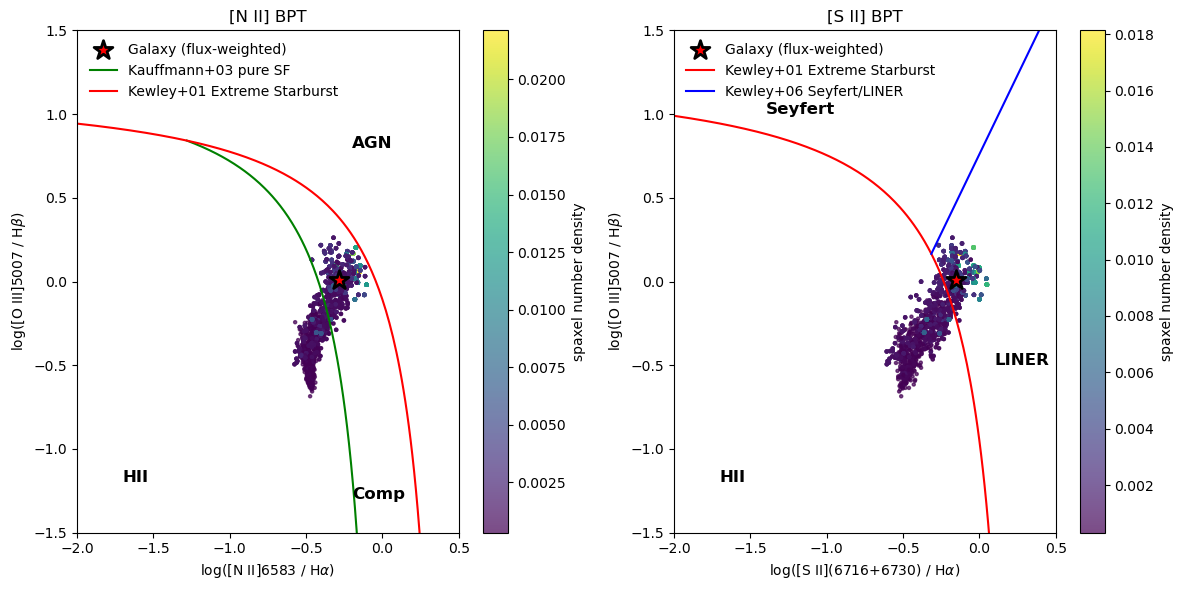

Galaxy flux-weighted representative points:
[N II] BPT: logN2 = -0.283, logO3 = 0.007
[S II] BPT: logS2 = -0.153, logO3 = 0.007
Number of spaxels in [N II] BPT regions:
HII: 4908, Comp: 42077, AGN: 37290
Number of spaxels in [S II] BPT regions:
HII: 6185, Seyfert: 7527, LINER: 69144


In [8]:
#  N II BPT -----------------------------------------
def kewley01_N2(x):   # max-starburst
    return 0.61/(x-0.47) + 1.19
def kauff03_N2(x):    # empirical SF upper envelope
    return 0.61/(x-0.05) + 1.30                            

#  S II BPT -----------------------------------------
def kewley01_S2(x):
    return 0.72/(x-0.32) + 1.30                           
def kewley06_Sy_LIN(x):   # Seyfert/LINER division
    return 1.89*x + 0.76        

# Calculate flux-weighted galaxy representative points
# Assuming you have a flux array (replace 'flux' with your actual flux variable name)
# If you don't have flux, you can use Ha_flux or another appropriate flux measurement
valid_mask_N2 = np.isfinite(logN2_cut) & np.isfinite(logO3_cut) 
valid_mask_S2 = np.isfinite(logS2_cut) & np.isfinite(logO3_cut) 

# Calculate flux-weighted representative points
galaxy_logN2 = np.log10(np.nansum(10**logN2_cut[valid_mask_N2] * 10**logN2_cut[valid_mask_N2]) / np.nansum(10**logN2_cut[valid_mask_N2]))
galaxy_logO3_N2 = np.log10(np.nansum(10**logO3_cut[valid_mask_N2] * 10**logO3_cut[valid_mask_N2]) / np.nansum(10**logO3_cut[valid_mask_N2]))
galaxy_logS2 = np.log10(np.nansum(10**logS2_cut[valid_mask_S2] * 10**logS2_cut[valid_mask_S2]) / np.nansum(10**logS2_cut[valid_mask_S2]))
galaxy_logO3_S2 = np.log10(np.nansum(10**logO3_cut[valid_mask_S2] * 10**logO3_cut[valid_mask_S2]) / np.nansum(10**logO3_cut[valid_mask_S2]))

fig, ax = plt.subplots(1, 2, figsize=(12,6))

# --- NII BPT -------------------------------------------------------
x = logN2_cut; y = logO3_cut
# Create a 2D histogram to get density information
valid_mask = np.isfinite(x) & np.isfinite(y)
x_valid = x[valid_mask]
y_valid = y[valid_mask]

h, xedges, yedges = np.histogram2d(x_valid, y_valid, bins=100)
# Assign density values to each point
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
density = np.zeros_like(x_valid)

for i, (xi, yi) in enumerate(zip(x_valid, y_valid)):
    x_idx = np.argmin(np.abs(x_centers - xi))
    y_idx = np.argmin(np.abs(y_centers - yi))
    density[i] = h[x_idx, y_idx] / len(x_valid)  # Normalize by the number of valid points

scatter = ax[0].scatter(x_valid, y_valid, s=5, c=density, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, ax=ax[0], label='spaxel number density')

# Add flux-weighted galaxy point
ax[0].scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='red', 
              edgecolors='black', linewidth=2, label='Galaxy (flux-weighted)', zorder=10)

xg = np.linspace((286-np.sqrt(2871561))/1100, 0.0, 200)
ax[0].plot(xg, kauff03_N2(xg), 'g-', lw=1.5, label='Kauffmann+03 pure SF')
xr = np.linspace(-2.0, 0.3, 200)
ax[0].plot(xr, kewley01_N2(xr), 'r-', lw=1.5, label='Kewley+01 Extreme Starburst')
ax[0].set_xlabel(r'log([N II]6583 / H$\alpha$)')
ax[0].set_ylabel(r'log([O III]5007 / H$\beta$)')
ax[0].set_xlim(-2.0, 0.5)
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_title('[N II] BPT')
ax[0].legend(frameon=False, loc='upper left')

# Add annotations for NII BPT
ax[0].text(-1.7, -1.2, 'HII', fontsize=12, fontweight='bold')
ax[0].text(-0.2, -1.3, 'Comp', fontsize=12, fontweight='bold')
ax[0].text(-0.2, 0.8, 'AGN', fontsize=12, fontweight='bold')

# --- SII BPT -------------------------------------------------------
x = logS2_cut; y = logO3_cut
# Create a 2D histogram for S II BPT
valid_mask = np.isfinite(x) & np.isfinite(y)
x_valid = x[valid_mask]
y_valid = y[valid_mask]

h, xedges, yedges = np.histogram2d(x_valid, y_valid, bins=100)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
density = np.zeros_like(x_valid)

for i, (xi, yi) in enumerate(zip(x_valid, y_valid)):
    x_idx = np.argmin(np.abs(x_centers - xi))
    y_idx = np.argmin(np.abs(y_centers - yi))
    density[i] = h[x_idx, y_idx] / len(x_valid)  # Normalize by the number of valid points

scatter = ax[1].scatter(x_valid, y_valid, s=5, c=density, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, ax=ax[1], label='spaxel number density')

# Add flux-weighted galaxy point
ax[1].scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='red', 
              edgecolors='black', linewidth=2, label='Galaxy (flux-weighted)', zorder=10)

ax[1].plot(xr, kewley01_S2(xr), 'r-', lw=1.5, label='Kewley+01 Extreme Starburst')
xb = np.linspace((159-np.sqrt(105081))/525, 0.5, 200)
ax[1].plot(xb, kewley06_Sy_LIN(xb), 'b-', lw=1.5, label='Kewley+06 Seyfert/LINER')
ax[1].set_xlabel(r'log([S II](6716+6730) / H$\alpha$)')
ax[1].set_ylabel(r'log([O III]5007 / H$\beta$)')
ax[1].set_xlim(-2.0, 0.5)
ax[1].set_ylim(-1.5, 1.5)
ax[1].set_title('[S II] BPT')
ax[1].legend(frameon=False)

# Add annotations for SII BPT
ax[1].text(-1.7, -1.2, 'HII', fontsize=12, fontweight='bold')
ax[1].text(-1.4, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
ax[1].text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')

plt.tight_layout(); plt.show()

# Print galaxy representative points
print(f"Galaxy flux-weighted representative points:")
print(f"[N II] BPT: logN2 = {galaxy_logN2:.3f}, logO3 = {galaxy_logO3_N2:.3f}")
print(f"[S II] BPT: logS2 = {galaxy_logS2:.3f}, logO3 = {galaxy_logO3_S2:.3f}")

# Count the number of spaxels in each region
N2_HII = logO3 <= kauff03_N2(logN2)
N2_Comp = (logO3 > kauff03_N2(logN2)) & (logO3 <= kewley01_N2(logN2))
N2_AGN = logO3 > kewley01_N2(logN2)
S2_HII = logO3 <= kewley01_S2(logS2)
S2_Seyfert = (logO3 > kewley01_S2(logS2)) & (logO3 > kewley06_Sy_LIN(logS2))
S2_LINER = (logO3 > kewley01_S2(logS2)) & (logO3 <= kewley06_Sy_LIN(logS2))
# Count the number of spaxels in each region
N2_HII_count = np.sum(N2_HII)
N2_Comp_count = np.sum(N2_Comp)
N2_AGN_count = np.sum(N2_AGN)
S2_HII_count = np.sum(S2_HII)
S2_Seyfert_count = np.sum(S2_Seyfert)
S2_LINER_count = np.sum(S2_LINER)
print(f"Number of spaxels in [N II] BPT regions:")
print(f"HII: {N2_HII_count}, Comp: {N2_Comp_count}, AGN: {N2_AGN_count}")
print(f"Number of spaxels in [S II] BPT regions:")
print(f"HII: {S2_HII_count}, Seyfert: {S2_Seyfert_count}, LINER: {S2_LINER_count}")

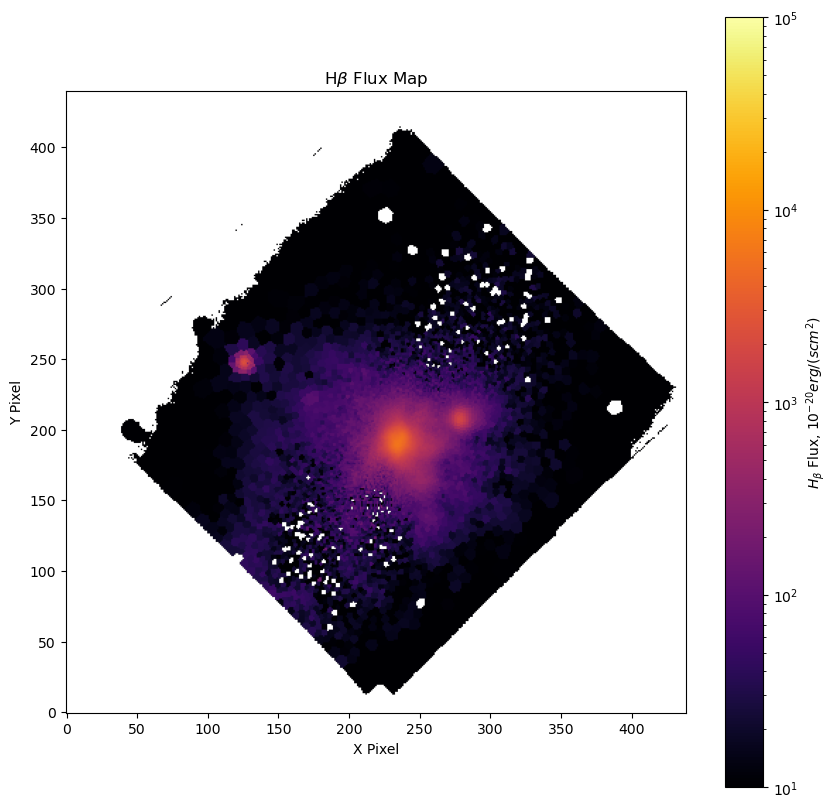

In [9]:
# Plot the Hbeta map
plt.figure(figsize=(10, 10))
plt.imshow(HB4861_FLUX, origin='lower', cmap='inferno', norm=LogNorm(vmin=10, vmax=1e5))
plt.colorbar(label=r'$H_\beta$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title(r'H$\beta$ Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

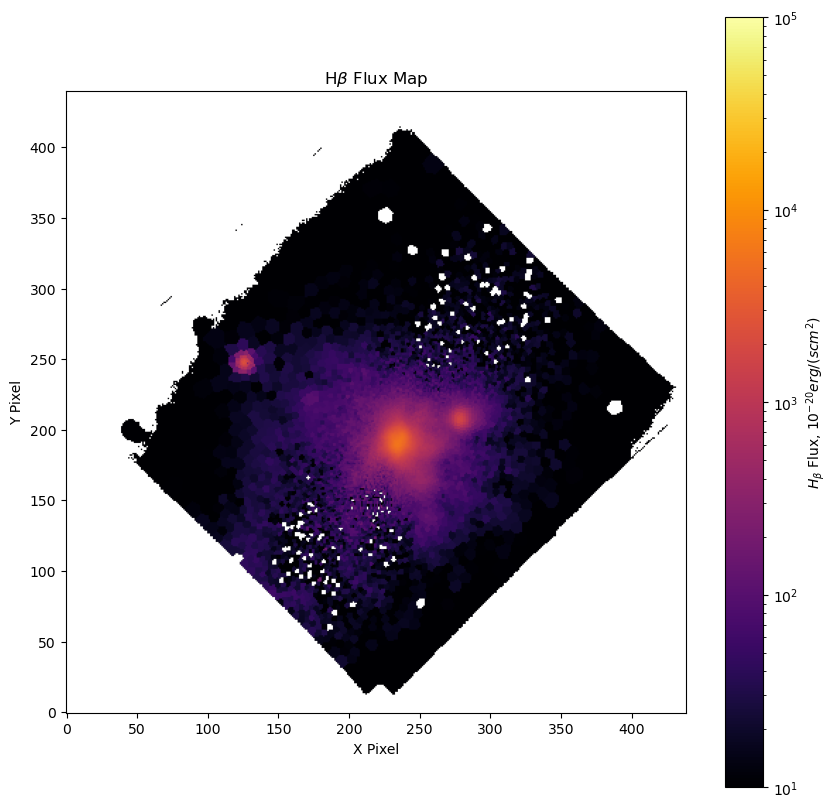

In [10]:
# Plot the Hbeta map
plt.figure(figsize=(10, 10))
plt.imshow(HB4861_FLUX, origin='lower', cmap='inferno', norm=LogNorm(vmin=10, vmax=1e5))
plt.colorbar(label=r'$H_\beta$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title(r'H$\beta$ Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

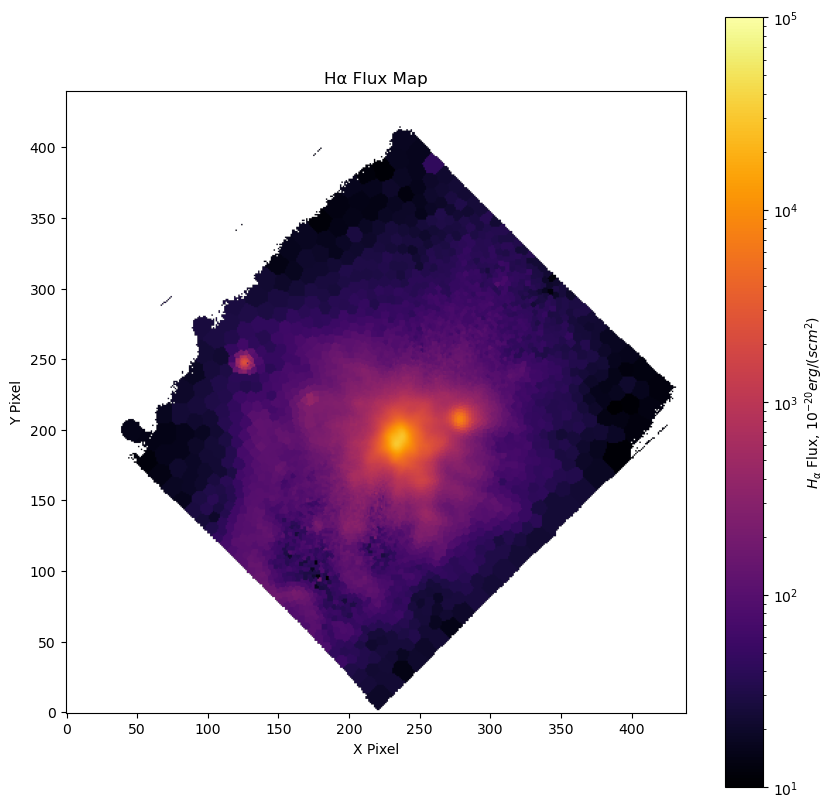

In [11]:
# Plot the Halpha map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=1e5))  # Logarithmic normalization
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title('Hα Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

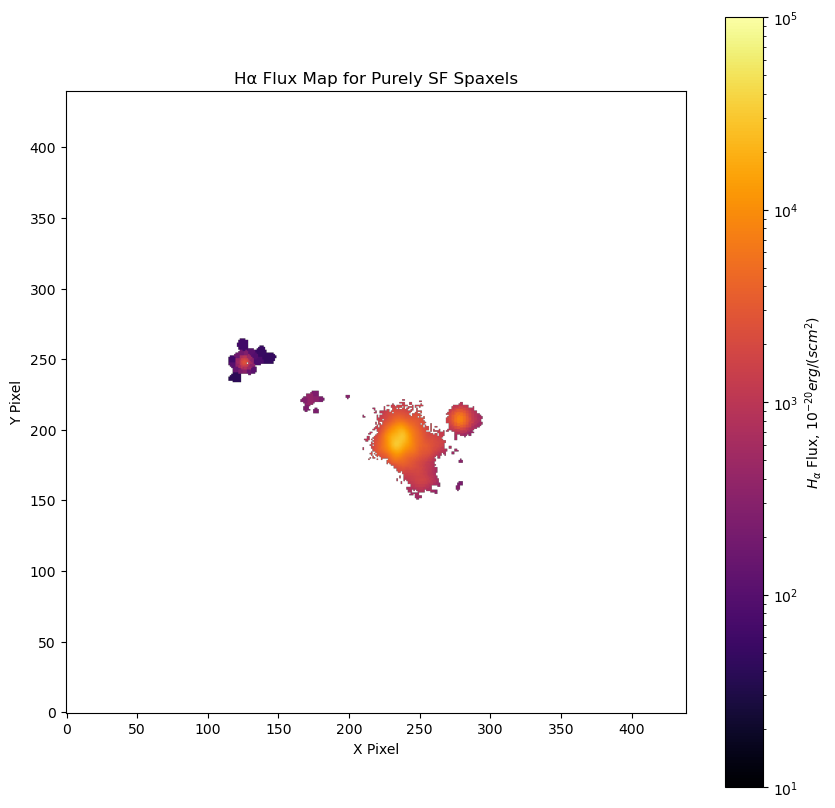

In [12]:
# Purely SF spaxels in both BPT diagram
mask_SF = (N2_HII+N2_Comp) & (S2_HII) #& (E_BV_BD > -0.5)  
# Apply the mask to the Halpha flux map
HA6562_FLUX_SF = np.where(mask_SF, HA6562_FLUX_cut, np.nan)
# Plot the Halpha map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX_SF, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=100000))
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title('Hα Flux Map for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

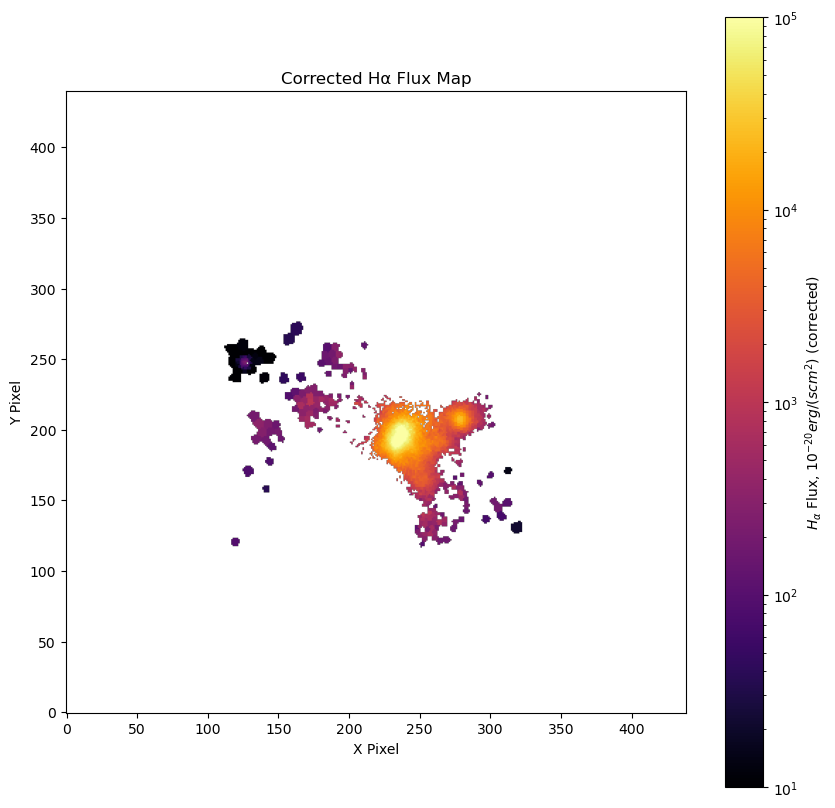

In [13]:
# Corrected Halpha map with E(B-V) from gas lines
HA6562_FLUX_corr = HA6562_FLUX_cut * 10**(0.4 * k_Ha * E_BV_BD)
# Plot the corrected Halpha map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX_corr, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=100000))
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$ (corrected)')
plt.title('Corrected Hα Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

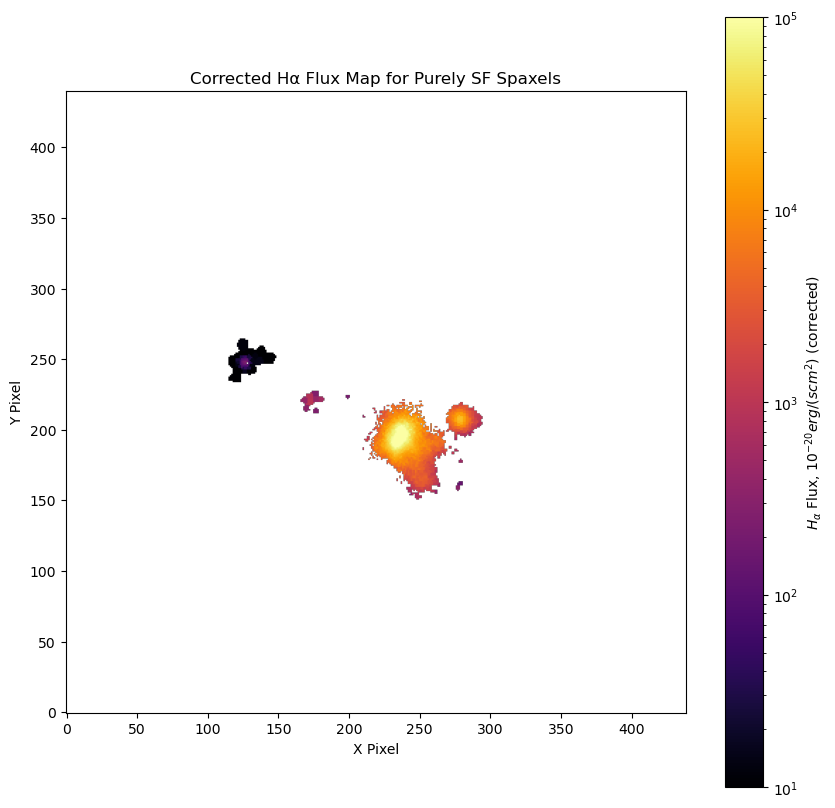

In [14]:
HA6562_FLUX_SF_corr = HA6562_FLUX_SF * 10**(0.4 * k_Ha * E_BV_BD)
# Plot the corrected Halpha map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX_SF_corr, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=100000))
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$ (corrected)')
plt.title('Corrected Hα Flux Map for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

Total corrected Hα Luminosity: 1.53e+40 erg / s erg/s
Total Hα Luminosity: 6.39e+39 erg / s 
Total corrected Hα Luminosity for purely SF spaxels: 1.45e+40 erg / s 
Total corrected log Hα Luminosity: 6.60 L_sun
Total corrected log Hα Luminosity for purely SF spaxels: 6.58 L_sun


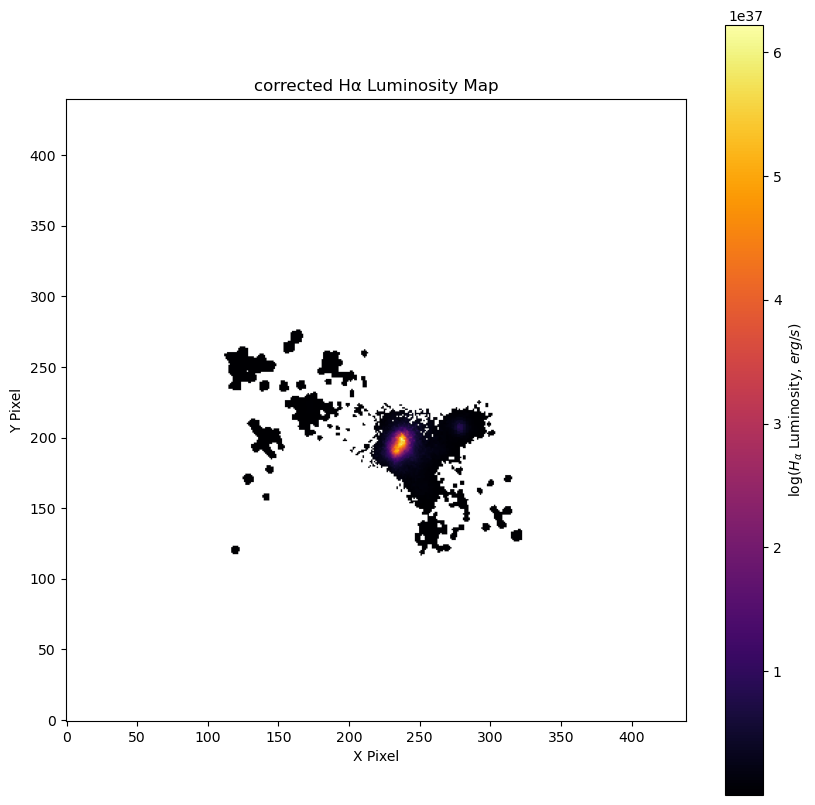

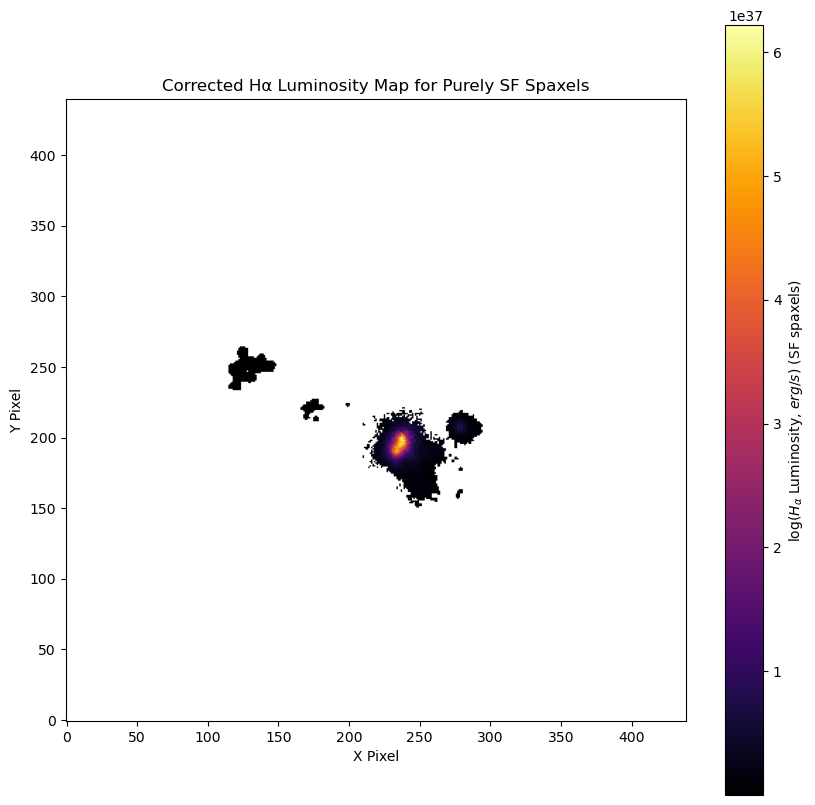

In [15]:
# Convert the corrected Halpha map ($10^{-20}erg/(s cm^2)$) to luminosity (erg/s)
def flux_to_luminosity(flux, distance=16.5):
    """
    Convert flux to luminosity.
    
    Parameters:
    flux : array-like
        Flux in erg/(s * Angstrom * cm^2).
    distance : float
        Distance in parsecs.
        
    Returns:
    luminosity : array-like
        Luminosity in erg/s.
    """
    return (flux*1e-20*u.erg/u.s/u.cm**2 * 4*np.pi*(distance*u.Mpc)**2).cgs

HA6562_Luminosity_corr = flux_to_luminosity(HA6562_FLUX_corr)
HA6562_Luminosity = flux_to_luminosity(HA6562_FLUX)
HA6562_Luminosity_SF_corr = flux_to_luminosity(HA6562_FLUX_SF_corr)
total_HA6562_Luminosity_corr = np.nansum(HA6562_Luminosity_corr)
total_HA6562_Luminosity = np.nansum(HA6562_Luminosity)
total_HA6562_Luminosity_SF_corr = np.nansum(HA6562_Luminosity_SF_corr)
log_halpha_corr = np.log10(HA6562_Luminosity_corr/c.L_sun.cgs)
total_log_halpha_corr = np.log10(total_HA6562_Luminosity_corr/c.L_sun.cgs)
total_log_halpha_SF_corr = np.log10(total_HA6562_Luminosity_SF_corr/c.L_sun.cgs)
print(f"Total corrected Hα Luminosity: {total_HA6562_Luminosity_corr:.2e} erg/s")
print(f"Total Hα Luminosity: {total_HA6562_Luminosity:.2e} ")
print(f"Total corrected Hα Luminosity for purely SF spaxels: {total_HA6562_Luminosity_SF_corr:.2e} ")
print(f"Total corrected log Hα Luminosity: {total_log_halpha_corr:.2f} L_sun")
print(f"Total corrected log Hα Luminosity for purely SF spaxels: {total_log_halpha_SF_corr:.2f} L_sun")
# Plot the corrected Halpha luminosity map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_Luminosity_corr , origin='lower', cmap='inferno')
plt.colorbar(label=r'log($H_\alpha$ Luminosity, $erg/s$)')
plt.title('corrected Hα Luminosity Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()
# Plot the corrected Halpha luminosity map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_Luminosity_SF_corr, origin='lower', cmap='inferno')
plt.colorbar(label=r'log($H_\alpha$ Luminosity, $erg/s$) (SF spaxels)')
plt.title('Corrected Hα Luminosity Map for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

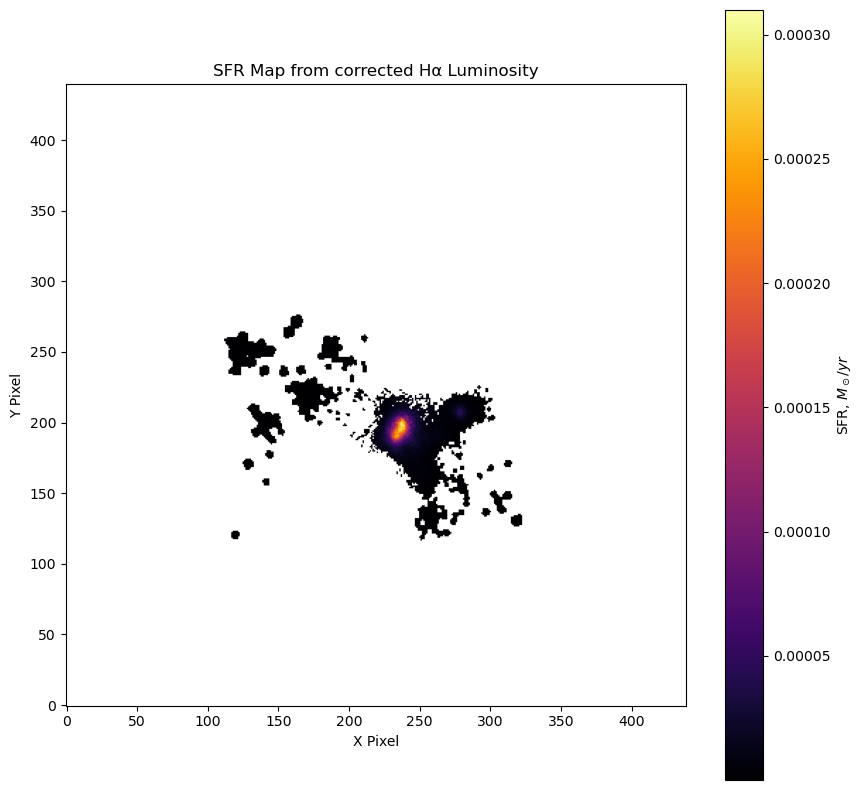

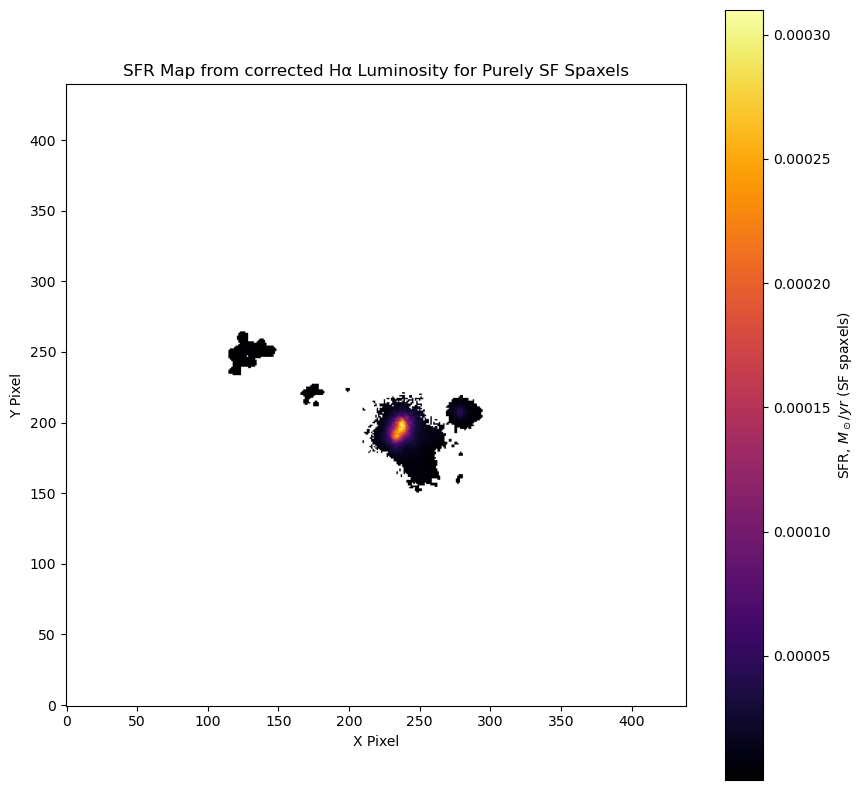

Total SFR from corrected Hα Luminosity: 0.08 M_sun/yr or log(SFR) = -1.12 M_sun/yr
Total SFR from corrected Hα Luminosity for purely SF spaxels: 0.07 M_sun/yr or log(SFR) = -1.14 M_sun/yr


In [16]:
# SFR map from Halpha luminosity, using Calzetti 2007
def calzetti_sfr(luminosity):
    """
    Convert Halpha luminosity to SFR using Calzetti 2007.
    But it is assuming the Kroupa IMF, 
    so we need to times a coefficient to go to Chabrier IMF.
    
    Parameters:
    luminosity : array-like
        Halpha luminosity in erg/s.
        
    Returns:
    sfr : array-like
        Star formation rate in solar masses per year.
    """
    return 5.3e-42 * luminosity.cgs.value / 0.67 *0.63 # SFR in M_sun/yr
HA6562_SFR_corr = calzetti_sfr(HA6562_Luminosity_corr)
total_HA6562_SFR_corr = calzetti_sfr(total_HA6562_Luminosity_corr)
HA6562_SFR_SF_corr = calzetti_sfr(HA6562_Luminosity_SF_corr)
total_HA6562_SFR_SF_corr = calzetti_sfr(total_HA6562_Luminosity_SF_corr)

# Plot the SFR map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_SFR_corr, origin='lower', cmap='inferno')
plt.colorbar(label=r'SFR, $M_\odot/yr$')
plt.title('SFR Map from corrected Hα Luminosity')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()
# Plot the SFR map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_SFR_SF_corr, origin='lower', cmap='inferno')
plt.colorbar(label=r'SFR, $M_\odot/yr$ (SF spaxels)')
plt.title('SFR Map from corrected Hα Luminosity for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

# Print the total SFR in the map
print(f"Total SFR from corrected Hα Luminosity: {total_HA6562_SFR_corr:.2f} M_sun/yr or log(SFR) = {np.log10(total_HA6562_SFR_corr):.2f} M_sun/yr")
print(f"Total SFR from corrected Hα Luminosity for purely SF spaxels: {total_HA6562_SFR_SF_corr:.2f} M_sun/yr or log(SFR) = {np.log10(total_HA6562_SFR_SF_corr):.2f} M_sun/yr")

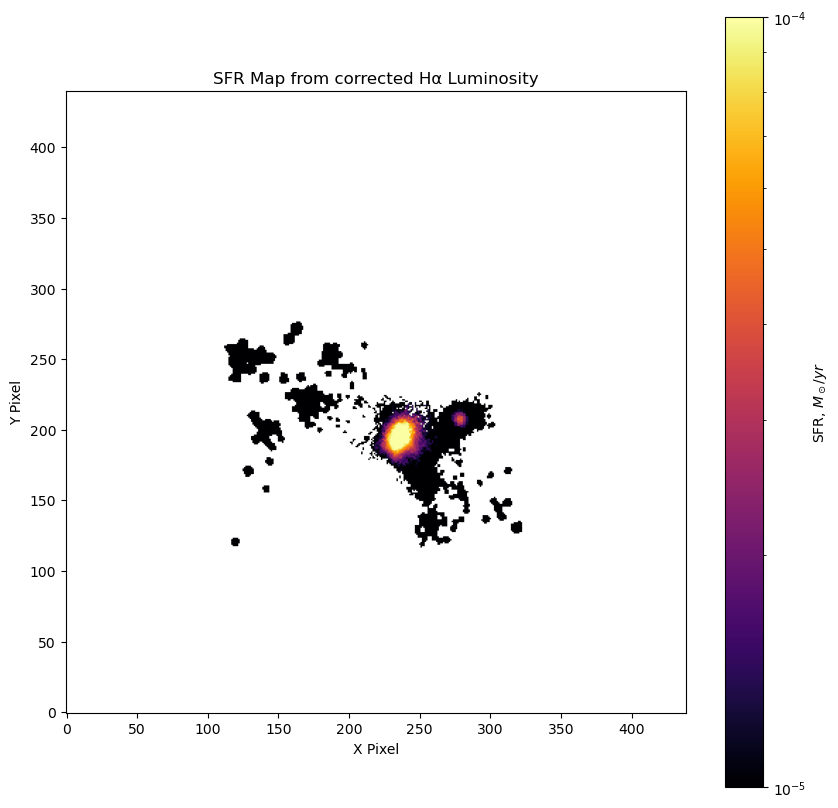

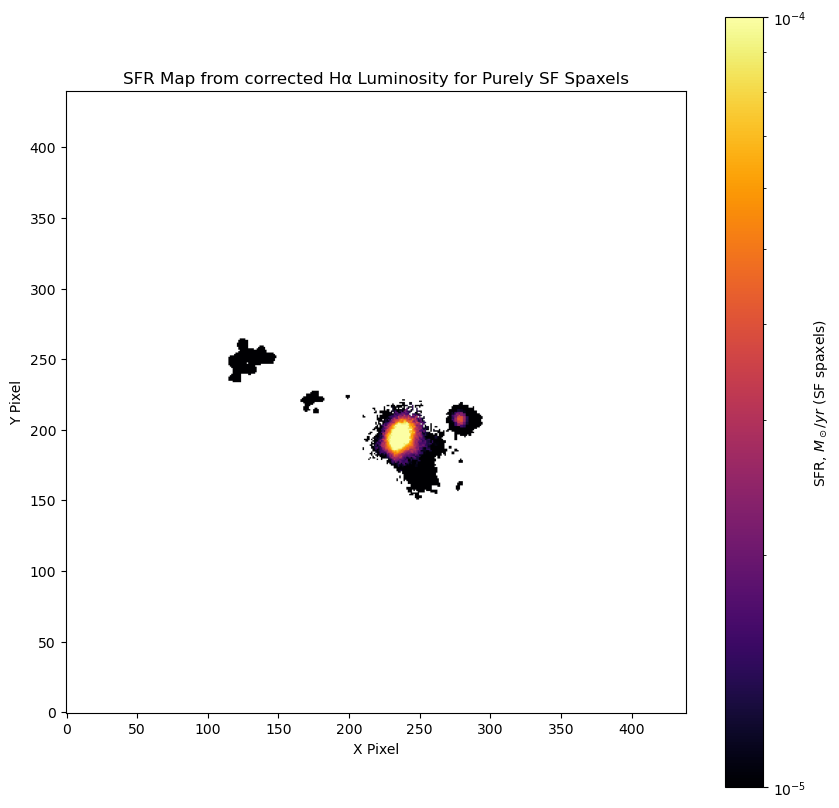

In [17]:
# Plot the SFR map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_SFR_corr, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=1e-5, vmax=1e-4))  
plt.colorbar(label=r'SFR, $M_\odot/yr$')
plt.title('SFR Map from corrected Hα Luminosity')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

# Plot the SFR map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_SFR_SF_corr, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=1e-5, vmax=1e-4))
plt.colorbar(label=r'SFR, $M_\odot/yr$ (SF spaxels)')
plt.title('SFR Map from corrected Hα Luminosity for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

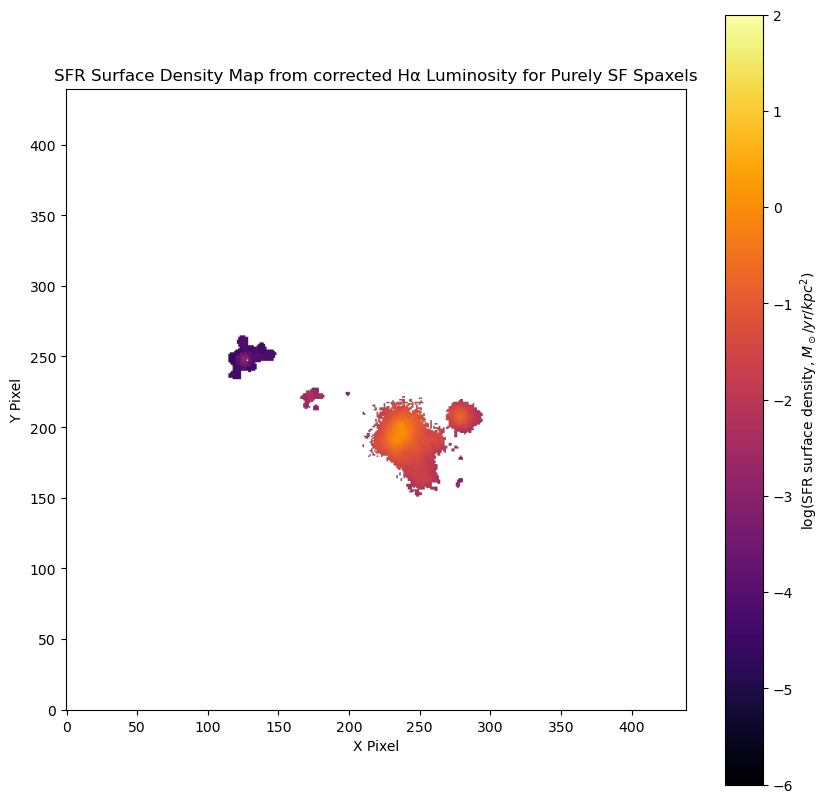

In [18]:
# Getting the SFR surface density 
# Convert to surface density in M☉/pc²
# 1. Convert pixel area to physical area in pc²
legacy_wcs2 = WCS(gas_header).celestial  # strip spectral axis
pixel_scale = (proj_plane_pixel_scales(legacy_wcs2) * u.deg).to(u.arcsec)
pixel_area_Mpc = ((pixel_scale[0]).to(u.rad).value*16.5*u.Mpc)*(((pixel_scale[1]).to(u.rad).value*16.5*u.Mpc))
pixel_area_kpc = pixel_area_Mpc.to(u.kpc**2)
# 2. Convert SFR to surface density
SFR_surface_density = HA6562_SFR_SF_corr / pixel_area_kpc  # M☉/yr/kpc²
# 3. Convert to log10 scale
log_SFR_surface_density = np.log10(SFR_surface_density.value)

# Plot the SFR surface density map
plt.figure(figsize=(10, 10))
plt.imshow(log_SFR_surface_density, origin='lower', cmap='inferno', 
           vmin=-6, vmax=2)  # Logarithmic normalization
plt.colorbar(label=r'log(SFR surface density, $M_\odot/yr/kpc^2$)')
plt.title('SFR Surface Density Map from corrected Hα Luminosity for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [19]:
binning_path = Path("NGC4694_SPATIAL_BINNING_maps_extended.fits")
print("Loading:", binning_path.resolve())
with fits.open(binning_path) as hdul:
    # check data structure and header
    print(hdul.info())
    binning_primary = hdul[0]
    # binning_BINID   = hdul['BINID'].data
    # binning_FLUX    = hdul['FLUX'].data
    # binning_SNR     = hdul['SNR'].data
    # binning_SNRBIN  = hdul['SNRBIN'].data
    # binning_XBIN    = hdul['XBIN'].data
    # binning_YBIN    = hdul['YBIN'].data
    binning_FLUX_R_corr    = hdul['FLUX_R_corr'].data
    binning_ML_R    = hdul['ML_R'].data
    binning_LOGMSTAR    = hdul['LOGMSTAR'].data
    binning_LOGMASS_SURFACE_DENSITY    = hdul['LOGMASS_SURFACE_DENSITY'].data
    binning_MAGNITUDE_R    = hdul['MAGNITUDE_R'].data
    # binning_MAGNITUDE_R_UNCORRECTED    = hdul['MAGNITUDE_R_UNCORRECTED'].data
    hdul.close()

Loading: /Users/Igniz/Desktop/ICRAR/extended/NGC4694_SPATIAL_BINNING_maps_extended.fits
Filename: NGC4694_SPATIAL_BINNING_maps_extended.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (439, 440)   float64   
  2  FLUX          1 ImageHDU        26   (439, 440)   float64   
  3  SNR           1 ImageHDU        26   (439, 440)   float64   
  4  SNRBIN        1 ImageHDU        26   (439, 440)   float64   
  5  XBIN          1 ImageHDU        26   (439, 440)   float64   
  6  YBIN          1 ImageHDU        26   (439, 440)   float64   
  7  FLUX_R_corr    1 ImageHDU        27   (439, 440)   float64   
  8  ML_R          1 ImageHDU        27   (439, 440)   float64   
  9  LOGMSTAR      1 ImageHDU        27   (439, 440)   float64   
 10  LOGMASS_SURFACE_DENSITY    1 ImageHDU        27   (439, 440)   float64   
 11  MAGNITUDE_R    1 ImageHDU        27   (439, 440)   float64   
 12  

None


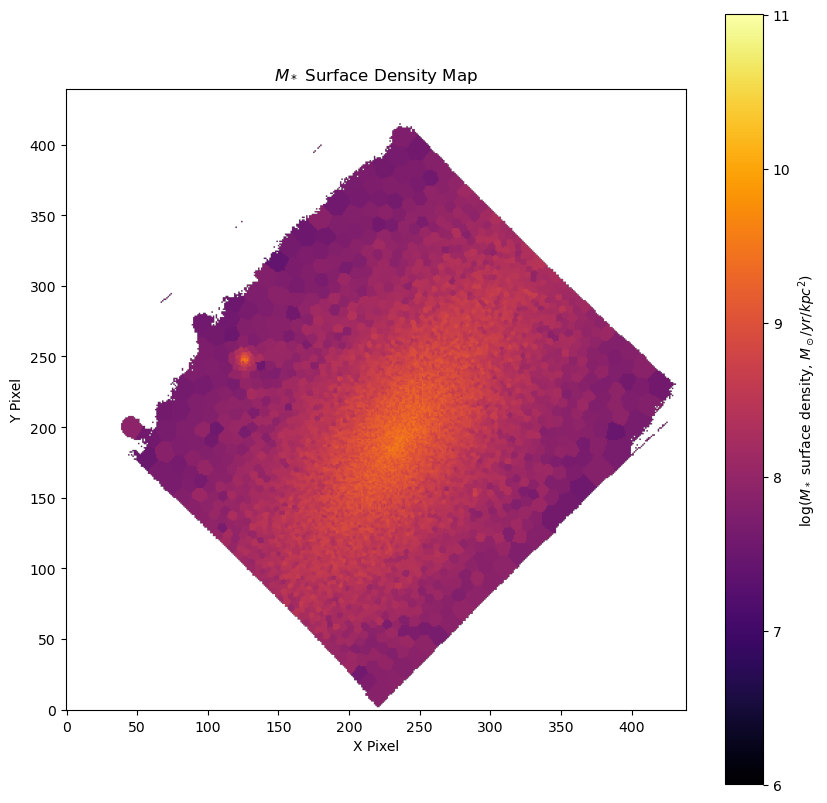

In [20]:
# Plot the M_* surface density map
plt.figure(figsize=(10, 10))
plt.imshow(binning_LOGMASS_SURFACE_DENSITY, origin='lower', cmap='inferno', 
           vmin=6, vmax=11)  # Logarithmic normalization
plt.colorbar(label=r'log($M_*$ surface density, $M_\odot/yr/kpc^2$)')
plt.title('$M_*$ Surface Density Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

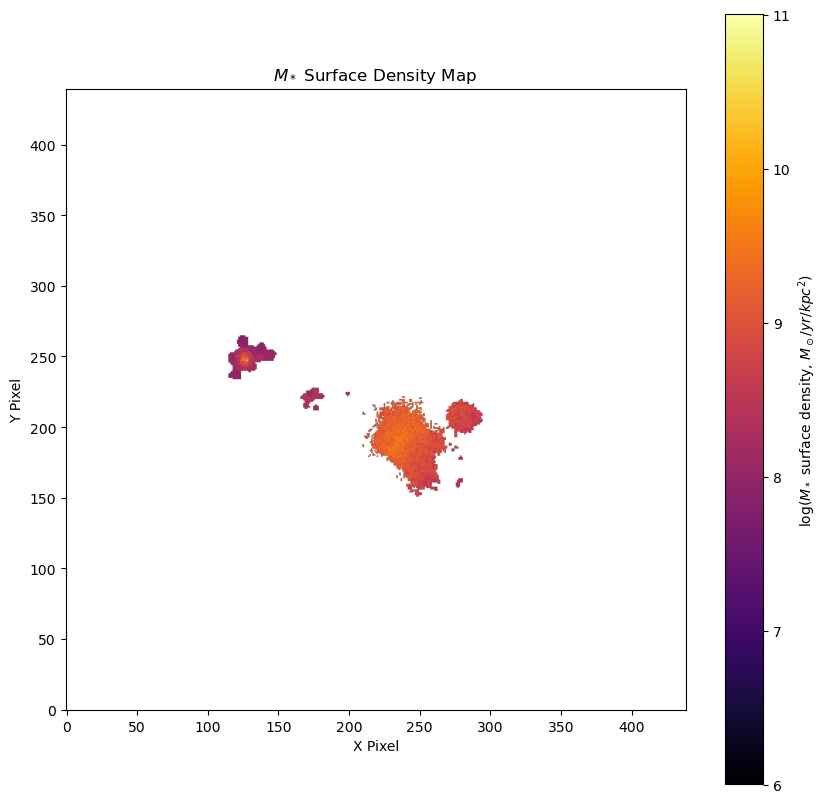

In [21]:
log_M_surface_density = np.where(mask_SF & mask_combined, binning_LOGMASS_SURFACE_DENSITY, np.nan)

# Plot the M_* surface density map
plt.figure(figsize=(10, 10))
plt.imshow(log_M_surface_density, origin='lower', cmap='inferno', 
           vmin=6, vmax=11)  # Logarithmic normalization
plt.colorbar(label=r'log($M_*$ surface density, $M_\odot/yr/kpc^2$)')
plt.title('$M_*$ Surface Density Map ')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

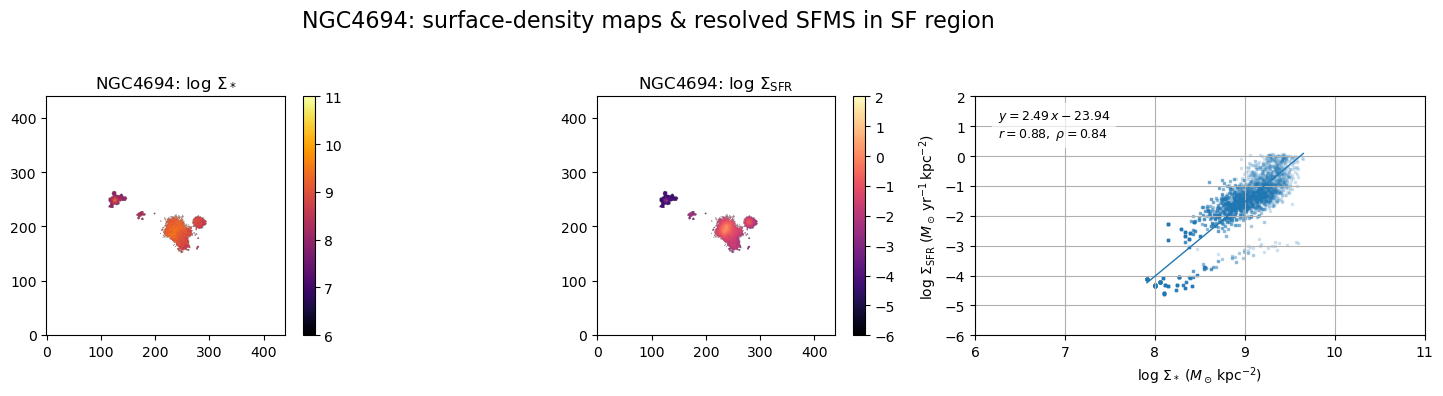

In [22]:
# ------------------------------------------------------------------
# 1.  Mask out any NaNs or Infs and do the regression
# ------------------------------------------------------------------
good = np.isfinite(log_M_surface_density) & np.isfinite(log_SFR_surface_density)
x = log_M_surface_density[good].ravel()
y = log_SFR_surface_density[good].ravel()

slope, intercept, r_value, p_value, _ = linregress(x, y)
rho, _ = spearmanr(x, y)
xx = np.linspace(x.min(), x.max(), 200)
yy = slope * xx + intercept

# ------------------------------------------------------------------
# 2.  Make the 1×3 figure
# ------------------------------------------------------------------
fig, (axM, axSFR, axSc) = plt.subplots(1, 3, figsize=(16, 4))

# --- Stellar-mass map ---
im1 = axM.imshow(log_M_surface_density, origin='lower', cmap='inferno', vmin=6, vmax=11)
axM.set_title(r'NGC4694: $\log\,\Sigma_*$')
fig.colorbar(im1, ax=axM, fraction=0.046, pad=0.04)

# --- SFR map ---
im2 = axSFR.imshow(log_SFR_surface_density, origin='lower', cmap='magma', vmin=-6, vmax=2)
axSFR.set_title(r'NGC4694: $\log\,\Sigma_{\mathrm{SFR}}$')
fig.colorbar(im2, ax=axSFR, fraction=0.046, pad=0.04)

# --- Resolved SFMS scatter ---
axSc.scatter(x, y, s=2, alpha=0.15, marker=',', color='C0')
axSc.plot(xx, yy, lw=1, color='C0')
axSc.set_xlabel(r'$\log\,\Sigma_* \;(M_\odot\,\mathrm{kpc}^{-2})$')
axSc.set_ylabel(
    r'$\log\,\Sigma_{\mathrm{SFR}}\;(M_\odot\,\mathrm{yr}^{-1}\,\mathrm{kpc}^{-2})$'
)
axSc.set_xlim(6, 11)
axSc.set_ylim(-6, 2)
axSc.grid(True)

stats = (
    fr'$y = {slope:.2f}\,x {intercept:+.2f}$' '\n'
    fr'$r = {r_value:.2f},\;\rho = {rho:.2f}$'
)
axSc.text(
    0.05, 0.95, stats,
    transform=axSc.transAxes,
    va='top', ha='left',
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

fig.suptitle('NGC4694: surface-density maps & resolved SFMS in SF region', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()
